# Preparation

Need to create a "common" folder under project folder. 
The folder includes: 

* {sex}_pd_gsmr.raw: for GSMR
* {sex}_pd_iv_1e4.txt: for MR-LDP
* {sex}_pd_iv_5e8.txt: for TwoSampleMR
* {sex}_pd_mrldp.raw: for MRLDP
* variants.tsv.bgz
* MR-LDP: [MR-LDP package](https://github.com/QingCheng0218/MR.LDP) downloaded
* mtag: [MTAG package](https://github.com/JonJala/mtag) downloaded

\* sex=['male', 'female', both_sexes']    
\* variants.tsv.bgz downloaded from Neale Lab    

Also, 

The first three types of files can be created by 

```
!python3 createCommonResource.py 
```

(and by createCommonResouce_both.ipynb for both_sexes)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pheno_dic = {
    '30880_irnt':'Urate (quantile)', 
    '30880_raw':'Urate (umol/L)', 
    '30800_irnt':'Oestradiol (quantile)', 
    '30800_raw':'Oestradiol (pmol/L)', 
    '30850_irnt':'Testosterone (quantile)', 
    '30850_raw':'Testosterone (nmol/L)', 
    '30830_irnt':'SHBG (quantile)',
    '30770_irnt':'IGF-1 (quantile)',
    '30840_irnt':'Total bilirubin (quantile)', 
    "30680_irnt":"Calcium (quantile)"}

pheno_dic2 = { # ukb_url is a bit different for these phenotypes
    '20002_1466':'Non-cancer illness code, self-reported: gout', # binary
    '20003_1140883066':'Treatment/medication code: insulin product',
    '100240':'Coffee consumed', 
    '20160':'Ever smoked', # binary
    '1239':'Current tobacco smoking', # binary
    '2644':'Light smokers, at least 100 smokes in lifetime', #binary
    '1558':'Alcohol intake frequency',
    '20016_irnt':'Fluid intelligence score (quantile)',
    '20016_raw':'Fluid intelligence score',
    '3581_irnt':'Age at menopause (last menstrual period, quantile)',
    '3581_raw':'Age at menopause (last menstrual period, raw)',
    '4194_irnt':'Pulse rate',
    'K58':'Diagnoses - main ICD10: K58 Irritable bowel syndrome',
    '100022':'Alcohol',
}
pheno_dic3={ # added
    '30600_irnt':'Albumin (quantile)',
    '30700_irnt':'Creatinine (quantile)',
    '30610_irnt':'Alkaline phosphatase (quantile)',
    '30620_irnt':'Alanine aminotransferase (quantile)',
    '30630_irnt':'Apoliprotein A (quantile)',
    '30640_irnt':'Apoliprotein B (quantile)',
    '30650_irnt':'Aspartate aminotransferase (quantile)',
    '30660_irnt':'Direct bilirubin (quantile)',
    '30670_irnt':'Urea (quantile)',
    '30680_raw':'Calcium (mmol/L)',
    '30690_irnt':'Cholesterol (quantile)',
    '30710_irnt':'C-reactive protein (quantile)',
    '30720_irnt':'Cystatin C (quantile)',
    '30730_irnt':'Gamma glutamyltransferase (quantile)',
    '30740_irnt':'Glucose (quantile)',
    '30750_irnt':'Glycated haemoglobin (quantile)',
    '30760_irnt':'HDL cholesterol (quantile)',
    '30780_irnt':'LDL direct (quantile)',
    '30790_irnt':'Lipoprotein A (quantile)',
    '30810_irnt':'Phosphate (quantile)',
    '30820_irnt':'Rheumatoid factor (quantile)',
    '30860_irnt':'Total protein (quantile)',
    '30870_irnt':'Triglycerides (quantile)',
    '30890_irnt':'Vitamin D (quantile)',
    '2714':'Age when periods started (menarche)',
}
pheno_dic.update(pheno_dic2)
pheno_dic.update(pheno_dic3)

wkdir='/data/CARD/projects/sexMRforPD'

In [ ]:
# production


cmd1 = []

# inputs

for pheno,annot in pheno_dic.items():
    
    if os.path.exists(f'{wkdir}/{pheno}'):
        print (f'{annot}: skip the analysis. Check {wkdir}/{pheno} folder')
        continue
    
    # download link changing flag
    if pheno=='dummy':
        flag=1
        continue
    
    cmd2=[]
    # cmd2 will be a list to create a one liner per pheno.
    # male MR > female MR > ldsc (male vs female)
    
    for sex in ['male', 'female', 'both_sexes']:
        
        # parameters
        uid=f'{wkdir}/{pheno}/{pheno}.{sex}' # unique data id
        ukb_url = f'https://broad-ukb-sumstats-us-east-1.s3.amazonaws.com/round2/additive-tsvs/{pheno}.gwas.imputed_v3.{sex}.varorder.tsv.bgz'
        if pheno in pheno_dic2.keys():
            ukb_url = f'https://broad-ukb-sumstats-us-east-1.s3.amazonaws.com/round2/additive-tsvs/{pheno}.gwas.imputed_v3.{sex}.tsv.bgz'
        input_file=f'{wkdir}/{pheno}/{pheno}.gwas.imputed_v3.{sex}.tsv.bgz'
        exposure_file=f'{uid}.5e8'
        exposure_file_raw=f'{uid}.raw'
        outcome_file=f'{wkdir}/common/{sex}_pd_gsmr.raw'
        bfile='/data/CARD/GENERAL/1000g_p3/euro_b/1000g_euro'
        filescreen=f'{uid}.1e4'
        fileexposure=f'{uid}.1e4'
        fileoutcome=f'{wkdir}/common/{sex}_pd_mrldp.raw'
        stringname3=f'{wkdir}/common/MR-LDP/all_chr_1000G'
        blockfile=f'{wkdir}/common/MR-LDP/fourier_ls-all.bed'
        harmonized_data=f'{uid}.mr_dat.csv'
        nthread=1
        
        # # create a folder
        cmd2.append(f'mkdir -p {wkdir}/{pheno}')
        
        # # downloading
        cmd2.append(f'wget {ukb_url} -O {input_file}')

        # # Preprocessing
        cmd2.append(f'python3 preprocess.py --uid {uid} --input {input_file} --nthread {nthread}')

        # # TwoSampleMR
        cmd2.append(f'Rscript --vanilla MR.R {uid} {exposure_file} {outcome_file}')

        # # GSMR
        cmd2.append(f'python3 GSMR.py --uid {uid} --bfile {bfile} --exposure {exposure_file_raw} --outcome {outcome_file}')

        # # MR-LDP (currently not working)
        cmd2.append(f'Rscript --vanilla MRLDP.R {uid} {filescreen} {fileexposure} {fileoutcome} {stringname3} {blockfile} {nthread}')

        # MR power
        cmd2.append(f'Rscript --vanilla power_MR.R {uid} {harmonized_data}')
    
    
    # ldsc regression of male vs felame
    ## need a processed files of both sex
    ref_ld_folder   = "/data/CARD/projects/sexMRforPD/common/mtag/ld_ref_panel/eur_w_ld_chr/"
    w_ld_chr_folder = "/data/CARD/projects/sexMRforPD/common/mtag/ld_ref_panel/eur_w_ld_chr/"
    file1=f'{wkdir}/{pheno}/{pheno}.male.ldsc.sumstats.gz'
    file2=f'{wkdir}/{pheno}/{pheno}.female.ldsc.sumstats.gz'
    outfile=f'{wkdir}/{pheno}/{pheno}.both.ldsc'

    cmd2.append(f'ldsc.py --rg {file1},{file2} --ref-ld-chr {ref_ld_folder} --w-ld-chr {w_ld_chr_folder} --out {outfile}')   
        
    cmd1.append((';').join(cmd2))

cmd=('\n').join(cmd1)
with open('mr.swarm', 'w') as f:
    f.write(cmd)


# 25G, 45 min for one uid. 

In [150]:
!swarm -f mr.swarm --time=2:00:00 -g 40 -p 2 -b 1 --logdir swarm --module=annovar/2019-10-24,ldsc/3d0c4464,R/4.1.0,GCTA/1.92.3beta3 --partition=quick  #--devel # 21773932,21776539

21776539


In [199]:
# !jobhist 21773932,21776539

In [ ]:
# some adjustment for phenotypes
cmd1=[]
for pheno,annot in {
    '3581_irnt':'Age at menopause (last menstrual period, quantile)', '3581_raw':'Age at menopause (last menstrual period, quantile)'
    }.items():
    
    cmd2=[]
    for sex in ['male', 'female']:
        
        # parameters
        uid=f'{wkdir}/{pheno}/{pheno}.{sex}' # unique data id
        exposure_file=f'{wkdir}/{pheno}/{pheno}.both_sexes.5e8'
        exposure_file_raw=f'{wkdir}/{pheno}/{pheno}.both_sexes.raw'
        outcome_file=f'{wkdir}/common/{sex}_pd_gsmr.raw'
        bfile='/data/CARD/GENERAL/1000g_p3/euro_b/1000g_euro'
        filescreen=f'{wkdir}/{pheno}/{pheno}.both_sexes.1e4'
        fileexposure=f'{wkdir}/{pheno}/{pheno}.both_sexes.1e4'
        fileoutcome=f'{wkdir}/common/{sex}_pd_mrldp.raw'
        stringname3=f'{wkdir}/common/MR-LDP/all_chr_1000G'
        blockfile=f'{wkdir}/common/MR-LDP/fourier_ls-all.bed'
        harmonized_data=f'{uid}.mr_dat.csv'
        nthread=1

        # # TwoSampleMR
        cmd2.append(f'Rscript --vanilla MR.R {uid} {exposure_file} {outcome_file}')

        # # GSMR
        cmd2.append(f'python3 GSMR.py --uid {uid} --bfile {bfile} --exposure {exposure_file_raw} --outcome {outcome_file}')

        # # MR-LDP (currently not working)
        cmd2.append(f'Rscript --vanilla MRLDP.R {uid} {filescreen} {fileexposure} {fileoutcome} {stringname3} {blockfile} {nthread}')

        # MR power
        cmd2.append(f'Rscript --vanilla power_MR.R {uid} {harmonized_data}')
        
        cmd1.append((';').join(cmd2))

cmd=('\n').join(cmd1)
# print(cmd)

# Populate LDSC results

In [115]:
!mkdir {wkdir}/fig

In [3]:
d = pd.DataFrame()
for pheno,annot in pheno_dic.items():
    file = f'{wkdir}/{pheno}/{pheno}.both.ldsc.log'
    if os.path.exists(file):
        t = pd.read_csv(file, delim_whitespace=True, header=None, 
                    names=['p1', 'p2', 'rg', 'se', 'z', 'p', 'h2_obs', 'h2_obs_se', 'h2_int', 'h2_int_se', 'gcov_int', 'gcov_int_se'])
        tt = t[t.p1.str.contains('ldsc.sumstats.gz')].copy()
        
        # add h2 for exposure
        target_rows=t[t.p1=='Total']
        if target_rows.shape[0]>1:
            tt['h2_exp']=target_rows.z.values[0]
            tt['h2_exp_se']=float(target_rows.p.values[0].replace('(', '').replace(')', ''))
            # add annotation
            tt['annot']=annot
            d = d.append(tt)
        else:
            print(pheno)
d.iloc[:, 2:14]=d.iloc[:, 2:14].apply(pd.to_numeric, errors='coerce')

3581_irnt
3581_raw
K58
30790_irnt
2714


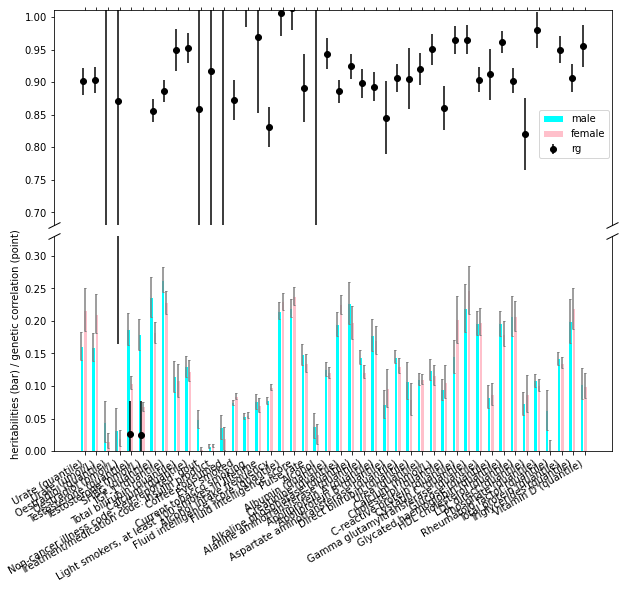

In [154]:
# width of the bars
barWidth = 0.3
bars1 = d.h2_exp
bars2 = d.h2_obs
pp = d.rg 

# Choose the height of the error bars (bars1)
yer1 = d.h2_exp_se
yer2 = d.h2_obs_se
pper  = d.se 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = (r1 + r2)/2
 
# two axes
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes
fig.set_size_inches(10,9)
fig.autofmt_xdate()

# Create plot
ax1.bar(r1, bars1, width = barWidth, color = 'cyan', edgecolor = 'white', yerr=yer1, capsize=1, ecolor='grey', label='male')
ax1.bar(r2, bars2, width = barWidth, color = 'pink', edgecolor = 'white', yerr=yer2, capsize=1, ecolor='grey', label='female')
ax1.errorbar(r3, pp, yerr=pper, fmt='o', color='black', label='rg')
ax2.bar(r1, bars1, width = barWidth, color = 'cyan', edgecolor = 'white', yerr=yer1, capsize=1, ecolor='grey', label='male')
ax2.bar(r2, bars2, width = barWidth, color = 'pink', edgecolor = 'white', yerr=yer2, capsize=1, ecolor='grey', label='female')
ax2.errorbar(r3, pp, yerr=pper, fmt='o', color='black', label='rg')
ax1.set_ylim([0.68,1.01])
ax2.set_ylim([0,0.33])

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.set_xticks([r + barWidth for r in range(len(bars1))])
ax2.set_xticklabels(d.annot)

k = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -k), (1, k)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


# general layout
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.6), borderaxespad=0.3)
plt.ylabel('heritabilities (bar) / genetic correlation (point)')


 
# Show graphic
plt.savefig(f'{wkdir}/fig/correlation.png')


In [17]:
analysis_set = [
    '30850_raw',
    '30830_irnt',
    '30800_raw',
    '30880_raw',
    '30890_irnt',
    '30680_raw',
    '30710_irnt',
    '30700_irnt',
    '30730_irnt',
    '30740_irnt',
    '20003_1140883066',
    '20016_raw']
# pheno_dic[pheno_dic.keys().isin.(analysis_set)]
analysis_set2 = [i for k, i in pheno_dic.items() if k in analysis_set]
d = d[d.annot.isin(analysis_set2)].copy()
d.shape

(12, 15)

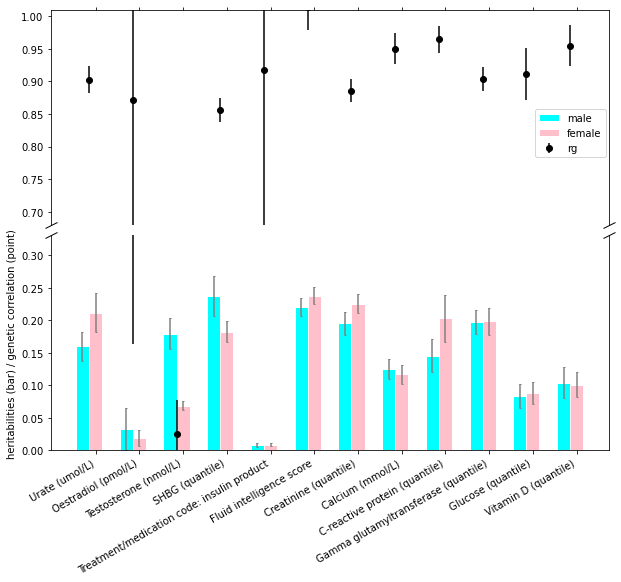

In [18]:

# width of the bars
barWidth = 0.3
bars1 = d.h2_exp
bars2 = d.h2_obs
pp = d.rg 

# Choose the height of the error bars (bars1)
yer1 = d.h2_exp_se
yer2 = d.h2_obs_se
pper  = d.se 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = (r1 + r2)/2
 
# two axes
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes
fig.set_size_inches(10,9)
fig.autofmt_xdate()

# Create plot
ax1.bar(r1, bars1, width = barWidth, color = 'cyan', edgecolor = 'white', yerr=yer1, capsize=1, ecolor='grey', label='male')
ax1.bar(r2, bars2, width = barWidth, color = 'pink', edgecolor = 'white', yerr=yer2, capsize=1, ecolor='grey', label='female')
ax1.errorbar(r3, pp, yerr=pper, fmt='o', color='black', label='rg')
ax2.bar(r1, bars1, width = barWidth, color = 'cyan', edgecolor = 'white', yerr=yer1, capsize=1, ecolor='grey', label='male')
ax2.bar(r2, bars2, width = barWidth, color = 'pink', edgecolor = 'white', yerr=yer2, capsize=1, ecolor='grey', label='female')
ax2.errorbar(r3, pp, yerr=pper, fmt='o', color='black', label='rg')
ax1.set_ylim([0.68,1.01])
ax2.set_ylim([0,0.33])

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.set_xticks([r + barWidth for r in range(len(bars1))])
ax2.set_xticklabels(d.annot)

k = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -k), (1, k)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


# general layout
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.6), borderaxespad=0.3)
plt.ylabel('heritabilities (bar) / genetic correlation (point)')


 
# Show graphic
plt.savefig(f'{wkdir}/fig/correlation.png')


# Populate MR results

In [16]:
import pandas as pd
import os

def populate_res(pheno, annot, sex):
    d = pd.DataFrame()
    file = f'{wkdir}/{pheno}/{pheno}.{sex}.mr_res.csv'
    if os.path.exists(file):
        res = pd.read_csv(file)
        d = d.append(res[['method', 'nsnp', 'b', 'se', 'pval']])

    file = f'{wkdir}/{pheno}/{pheno}.{sex}.gsmr.res.gsmr'
    if os.path.exists(file):
        res = pd.read_csv(file, sep='\t')
        res['method'] = 'GSMR'
        res = res.rename(columns={'bxy':'b', 'p':'pval'})
        d = d.append(res[['method', 'nsnp', 'b', 'se', 'pval']])

    file = f'{wkdir}/{pheno}/{pheno}.{sex}.mrldp.csv'
    if os.path.exists(file):
        res = pd.read_csv(file)
        res['method'] = 'MR-LDP'
        d = d.append(res.loc[res.lam==0.85, ['method', 'nsnp', 'b', 'se', 'pval']])

    d['sex'] = sex
    d['pheno']= pheno
    d['annot']= annot
    if d.shape[0]>0:
        return (d[['pheno', 'annot', 'sex','method', 'nsnp', 'b', 'se', 'pval']])

d=pd.DataFrame()
for pheno,annot in pheno_dic.items():
    for sex in ['male', 'female', 'both_sexes']:
        d = d.append(populate_res(pheno, annot, sex))
d.to_csv('MR.summary.csv', index=False)
d[(d.method=='GSMR')&(d.pval<0.05)]

,pheno,annot,sex,method,nsnp,b,se,pval
0,30830_irnt,SHBG (quantile),female,GSMR,244.0,-0.100834,0.048886,0.039146
0,30770_irnt,IGF-1 (quantile),both_sexes,GSMR,838.0,0.104645,0.041718,0.012129
0,20003_1140883066,Treatment/medication code: insulin product,male,GSMR,30.0,-5.829710,1.497510,0.000099
0,20003_1140883066,Treatment/medication code: insulin product,female,GSMR,31.0,-8.269610,2.501110,0.000945
0,20160,Ever smoked,both_sexes,GSMR,54.0,-0.926513,0.434879,0.033130
0,1239,Current tobacco smoking,both_sexes,GSMR,21.0,-1.513280,0.621188,0.014847
0,1558,Alcohol intake frequency,male,GSMR,10.0,-0.608268,0.205637,0.003097
0,20016_irnt,Fluid intelligence score (quantile),female,GSMR,15.0,0.435253,0.205134,0.033854
0,20016_raw,Fluid intelligence score,female,GSMR,15.0,0.223640,0.099563,0.024691
0,20016_raw,Fluid intelligence score,both_sexes,GSMR,50.0,0.157776,0.061086,0.009799


In [17]:
d[d.pval<0.01]

,pheno,annot,sex,method,nsnp,b,se,pval
0,30800_irnt,Oestradiol (quantile),female,Wald ratio,1.0,-1.578340,0.566953,0.005371
1,30680_irnt,Calcium (quantile),female,Weighted median,90.0,0.380990,0.142503,0.007505
2,20003_1140883066,Treatment/medication code: insulin product,male,Inverse variance weighted,6.0,-6.624493,2.321636,0.004326
0,20003_1140883066,Treatment/medication code: insulin product,male,GSMR,30.0,-5.829710,1.497510,0.000099
0,20003_1140883066,Treatment/medication code: insulin product,female,GSMR,31.0,-8.269610,2.501110,0.000945
1,1558,Alcohol intake frequency,male,Weighted median,9.0,-0.791874,0.281411,0.004894
2,1558,Alcohol intake frequency,male,Inverse variance weighted,9.0,-0.689771,0.212297,0.001158
0,1558,Alcohol intake frequency,male,GSMR,10.0,-0.608268,0.205637,0.003097
0,20016_raw,Fluid intelligence score,both_sexes,GSMR,50.0,0.157776,0.061086,0.009799
1,30680_raw,Calcium (mmol/L),female,Weighted median,86.0,4.094632,1.534595,0.007626


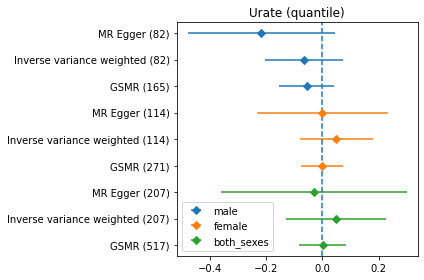

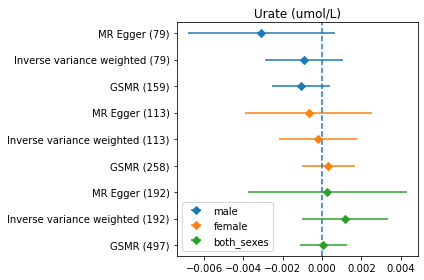

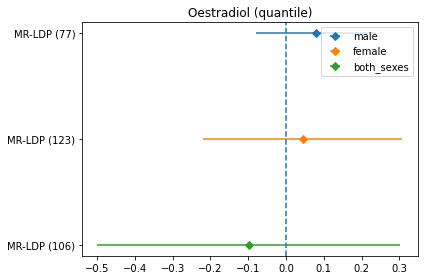

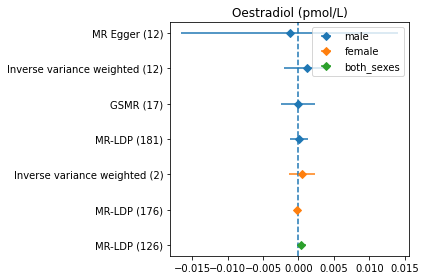

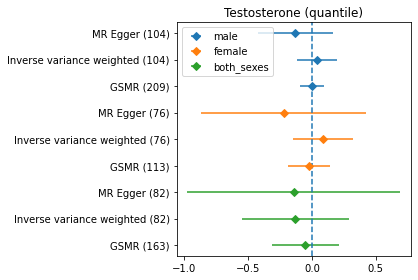

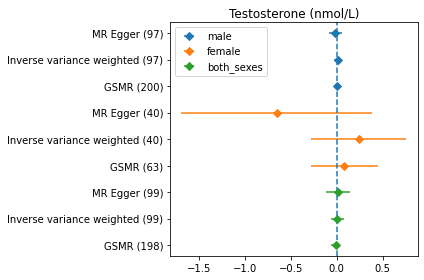

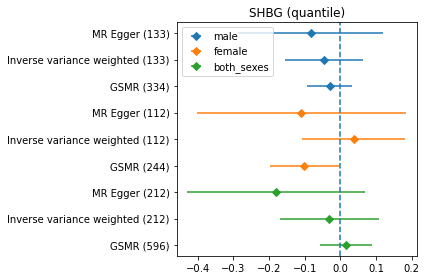

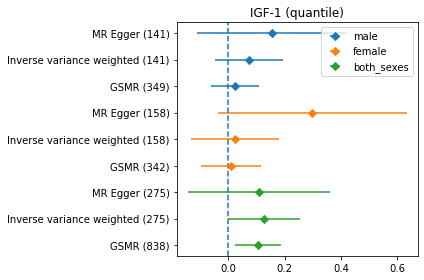

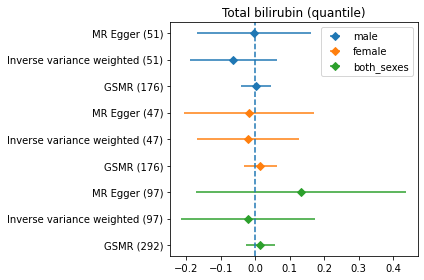

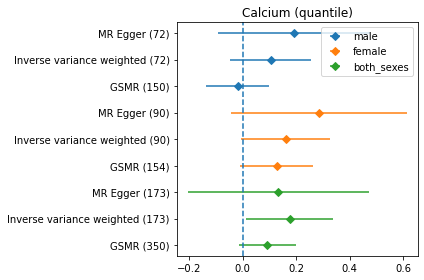

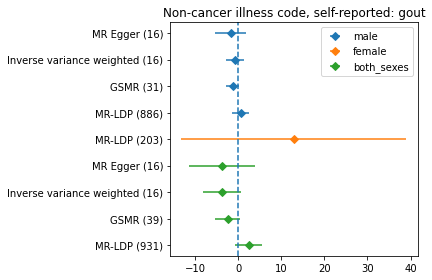

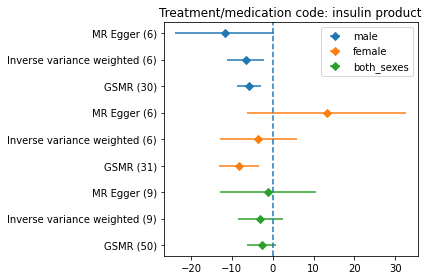

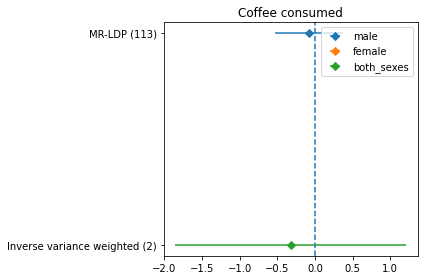

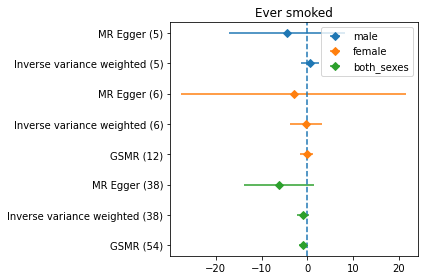

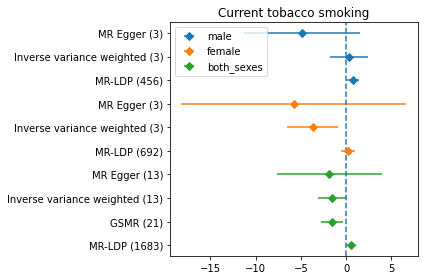

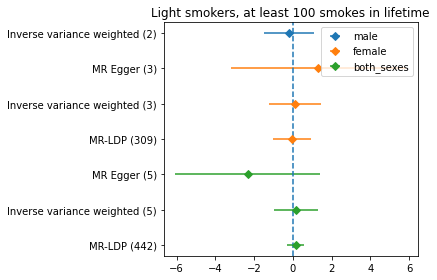

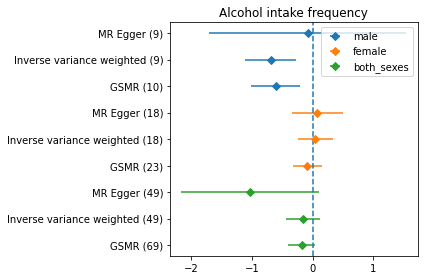

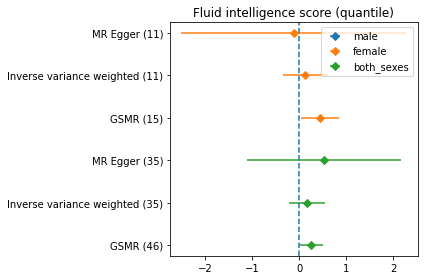

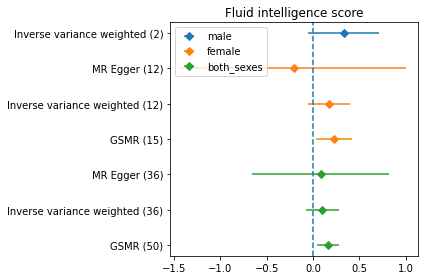

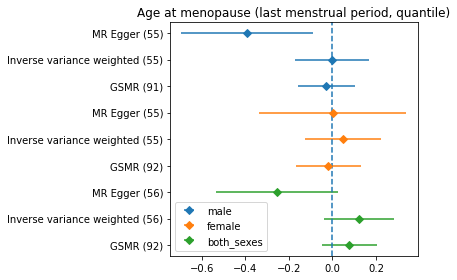

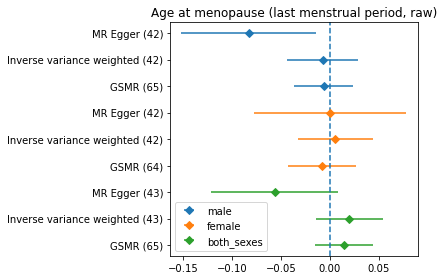

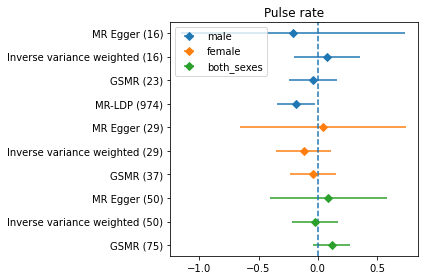

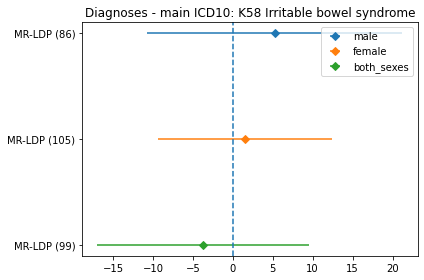

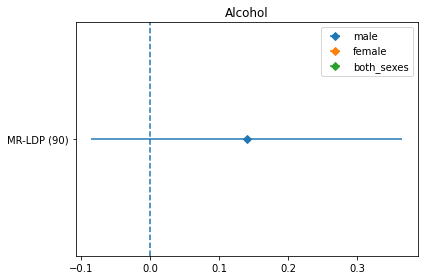

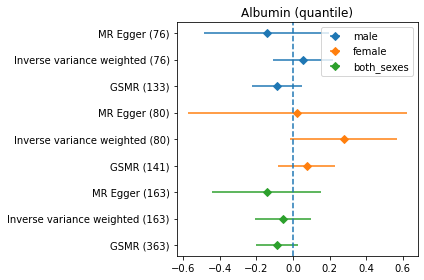

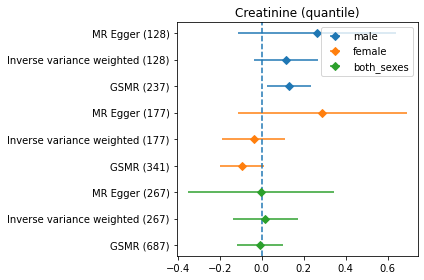

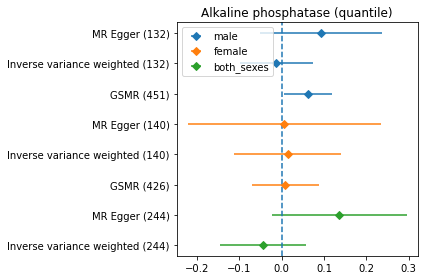

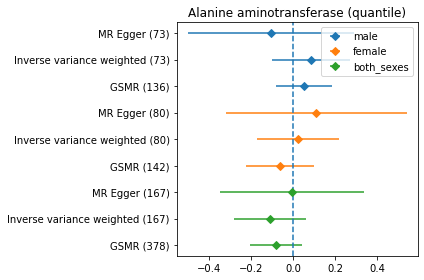

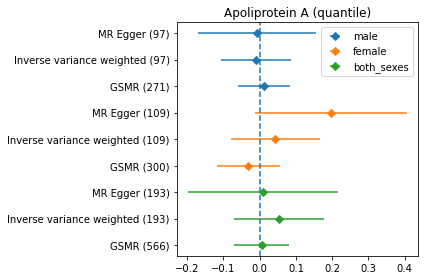

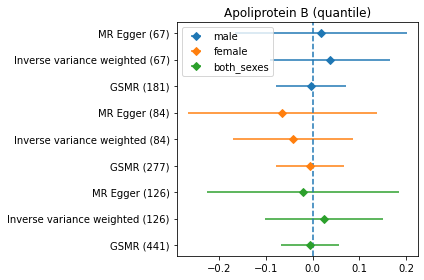

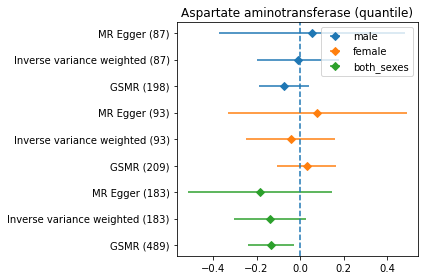

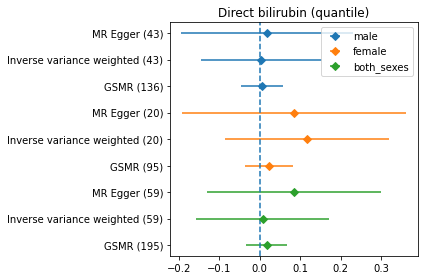

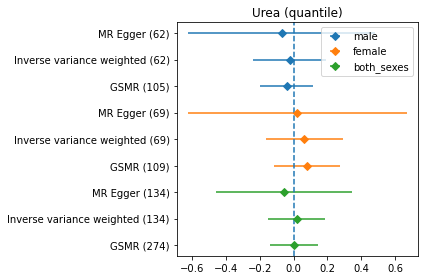

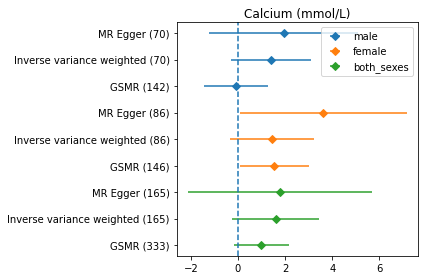

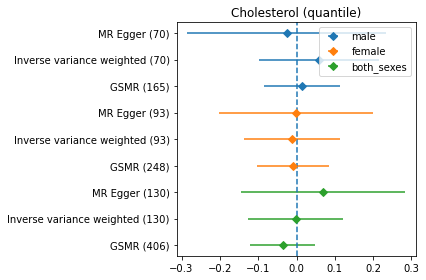

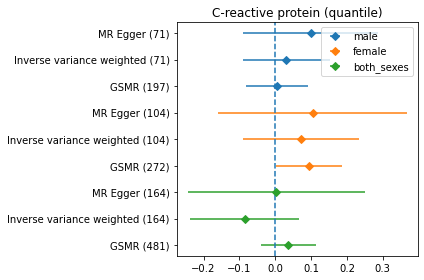

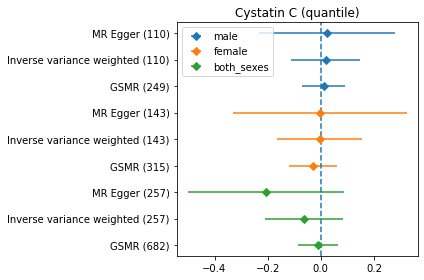

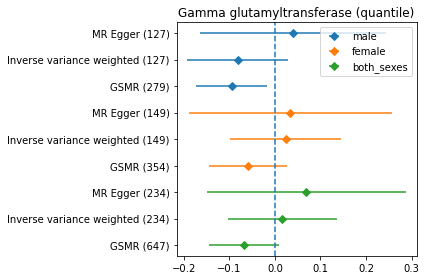

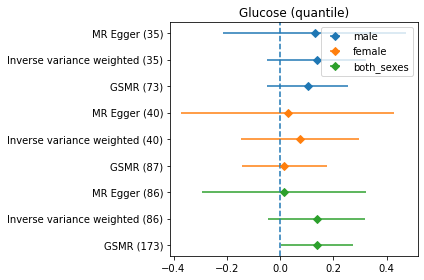

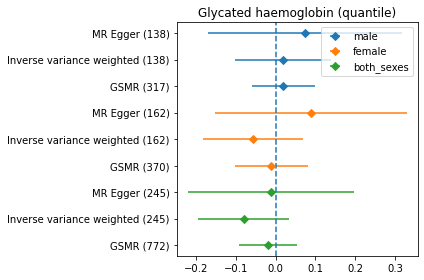

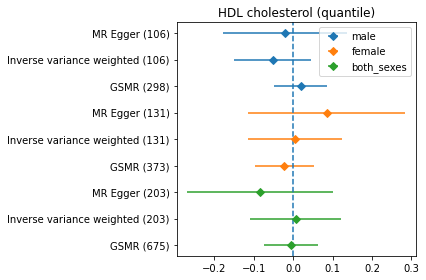

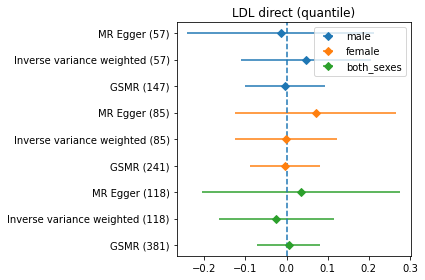

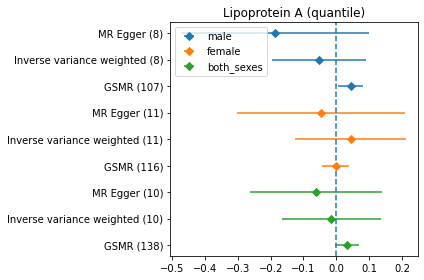

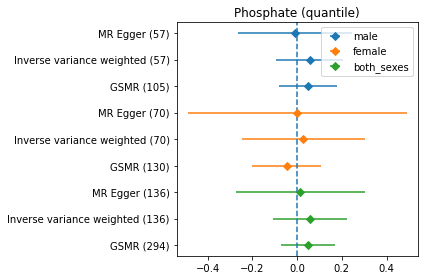

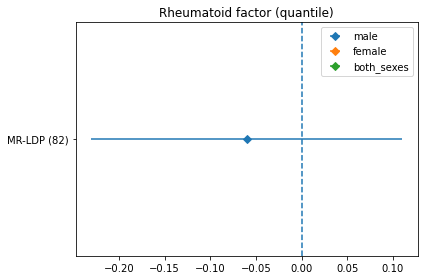

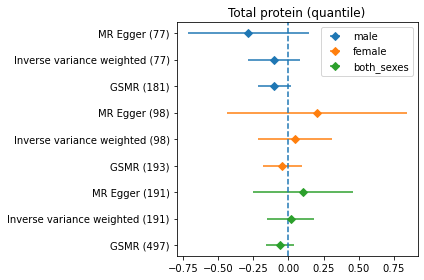

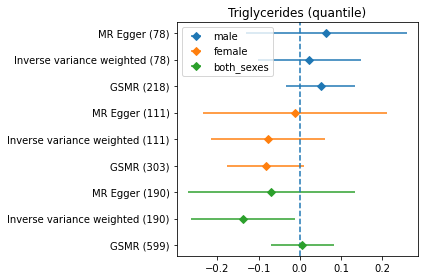

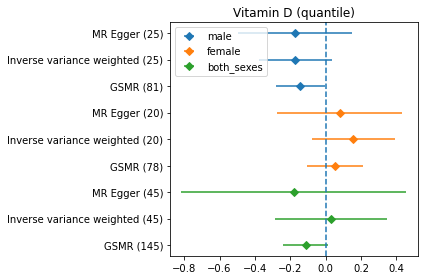

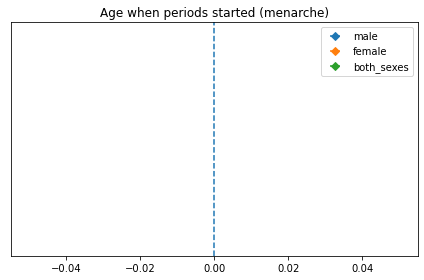

In [3]:
import numpy as np
import matplotlib.pyplot as plt

for pheno,annot in pheno_dic.items():
    t=d[(d.pheno==pheno)&(d.method.isin(['MR Egger', 'Inverse variance weighted', 'GSMR', 'MR-LDP']))&(pd.notna(d.se))]
    annot=pheno_dic[pheno]
    labs=[]
    r1 = [i for i in reversed(range(len(t.b)))]
    for sex in ['male', 'female', 'both_sexes']:
        di=t[t.sex==sex]
        pp = di.b
        pper = di.se * 1.96
        yi=r1[:len(pp)]
        labs.extend([f'{m} ({n:.0f})' for m, n in zip(di.method, di.nsnp)])
        plt.errorbar(pp, yi, xerr=pper, fmt='D', label=sex)
        r1=r1[len(pp):]
    r1 = [i for i in reversed(range(len(t.b)))]
    plt.axvline(x=0, ls='--')
    plt.legend()
    plt.title(annot)
    plt.yticks(r1, labs, rotation=0)
    plt.tight_layout() 
    plt.savefig(f'{wkdir}/fig/{pheno}.png')
    plt.show()

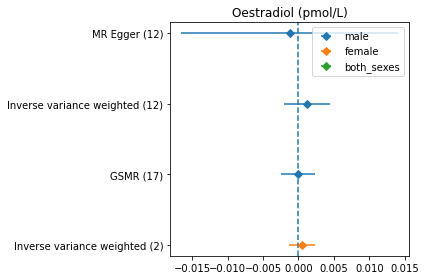

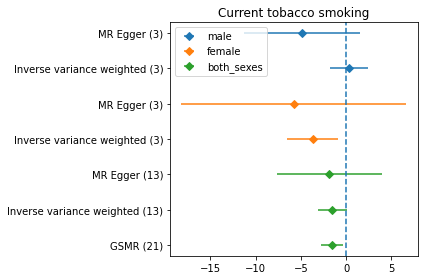

In [20]:
# pin point without MR-MDP
import numpy as np
import matplotlib.pyplot as plt

for pheno,annot in pheno_dic.items():
    if pheno in ['1239', '30800_raw']:
        t=d[(d.pheno==pheno)&(d.method.isin(['MR Egger', 'Inverse variance weighted', 'GSMR']))&(pd.notna(d.se))]
        annot=pheno_dic[pheno]
        labs=[]
        r1 = [i for i in reversed(range(len(t.b)))]
        for sex in ['male', 'female', 'both_sexes']:
            di=t[t.sex==sex]
            pp = di.b
            pper = di.se * 1.96
            yi=r1[:len(pp)]
            labs.extend([f'{m} ({n:.0f})' for m, n in zip(di.method, di.nsnp)])
            plt.errorbar(pp, yi, xerr=pper, fmt='D', label=sex)
            r1=r1[len(pp):]
        r1 = [i for i in reversed(range(len(t.b)))]
        plt.axvline(x=0, ls='--')
        plt.legend()
        plt.title(annot)
        plt.yticks(r1, labs, rotation=0)
        plt.tight_layout() 
        plt.savefig(f'{wkdir}/fig/{pheno}_2.png')
        plt.show()

In [8]:
%%bash
# Menopousal age MR replicatio
Rscript --vanilla MR_monopause_rep.R \
 /data/CARD/projects/sexMRforPD/3581_raw/3581_raw.female \
 /data/CARD/projects/sexMRforPD/3581_raw/3581_raw.both_sexes.5e8 \
 /data/CARD/projects/sexMRforPD/common/female_pd_gsmr.raw

TwoSampleMR version 0.5.6 
[>] New: Option to use non-European LD reference panels for clumping etc
[>] Some studies temporarily quarantined to verify effect allele
[>] See news(package='TwoSampleMR') and https://gwas.mrcieu.ac.uk for further details

No phenotype name specified, defaulting to 'exposure'.
Warning message:
In .fun(piece, ...) :
  Duplicated SNPs present in exposure data for phenotype 'exposure. Just keeping the first instance:
rs199672393
rs386644222
rs545396363
No phenotype name specified, defaulting to 'outcome'.
Harmonising exposure (vMdPoQ) and outcome (eT2pXS)
Analysing 'vMdPoQ' on 'eT2pXS'
